# Redes Neurais Quânticas

## Introdução


As redes neurais artificiais são modelos computacionais para aprendizagem de máquina que ganharam significativa força nos últimos anos devido ao aumento do volume de dados e na capacidade de processamento de placas dedicadas. Esta tecnologia vem impactando todas as áreas de produção como agricultura, saúde, mineração, transportes, dentre outras. Dentre as possibilidades de plataformas para realização da computação das redes neurais artificiais, os computadores quânticos têm se mostrado uma possibilidade factível para gerar valor para essa área.

Uma propriedade da Mecânica Quântica é a de processar e armazenar grandes vetores e matrizes complexas e realizar operações lineares em tais vetores, resultando em um aumento exponencial na capacidade de desenvolvimento de redes neurais diretamente implementadas em um computador quântico.

O modelo mais simples de rede neural artificial foi proposto por Rosenblatt em 1957, uma vetor de valores reais $I$ com dimensão $m$, que representa o input de informações, e um vetor  de valores reais $W$ que representa os pesos da rede. O output da rede é dado pelo produto interno entre os vetores $I$ e $W$ que resulta numa probabilidade associada a uma decisão binária (sim/não). Nas implementações mais simples $I$ e $W$ possuem valores binários e apesar de serem limitados, são a base das redes neurais mais complexas que existem hoje em dia.

![](img/rede.png)


## Implementação do artigo "An artificial neuron implemented on an actual quantum processor"

No artigo “An artificial neuron implemented on an actual quantum processor” os autores propõem uma alternativa inspirada pela rede neural de Rosenblatt. Primeiramente os vetores de input e pesos de dimensão $M$ são computados no computador quântico usando $N$ qubits, de modo que $M = 2^N$. Isso explicita a vantagem informacional do computador quântico. Os autores também implementam um procedimento para gerar múltiplos estados de emaranhamento que permitiram diminuir os recursos computacionais necessários para gerar o algoritmo.

![](img/circuito.png)

De maneira prática, o sistema quântico é inicializado numa operação unitária $U_i$, que representa a entrada de dados, segue para um operação unitária $U_w$ que representa os pesos da rede neural e o resultado é extraído por meio de um bit auxiliar (ancilla) que é usado para aplicar uma porta NOT multi controlada a fim de mensurar o estado de ativação do perceptron. A mensuração da ancila produz um output do estado ativado do perceptron com probabilidade $|C_m-1|^2$.
    

![](img/image6.png)

Como observado no circuito acima, vamos definir o circuito $U_i$ que será a entrada representativa dos dados. No exemplo demonstrado no artigo foram simuladas imagens 4x4 pixels que totalizam 16 pixels, cada um representando um valor binário (branco ou preto) que será implementado no algoritmo quântico por meio de uma inversão de sinal da porta lógica $Z$ e $C_nZ$.

![](img/image5.png)

# Uw

Como dito, a primeira fase do algoritmo consiste em realizar o produto interno entre um vetor $i$ de entrada e outro vetor $w$ de pesos. Para realizar isso, são usados dois operadores unitários. Um deles, $U_w$, tem a seguinte visualização geométrica



![](img/image01.png)

Primeiramente, em verde, é feita uma projeção do vetor $|\Psi i\rangle$ no vetor $|\Psi w\rangle$. Então, $U_w$ rotaciona $|\Psi w\rangle$ até alinhá-lo com $|111...11\rangle$ e também rotaciona $|\Psi i\rangle$ na mesma proporção. O produto interno $i.\Psi$ é representado pela projeção de $U_w|\Psi i\rangle$ no eixo $|111...11\rangle$ 

No artigo, são sugeridas duas abordagens: Força bruta a partir de sucessivas rotações e uma abordagem utilizando hipergrafos. A segunda, sugere uma definição pouco conhecida, mas nada mirabolante.

![](img/grafohipergrafo.png)

Nos grafos, se as arestas são relacionamentos, esses relacionamentos são de 1:1. Ou seja, um relacionamento (uma aresta) não pode sair de um vértice em direção a vários outros. Nos hipergrafos, no entanto, isso é possível. Neles, uma aresta pode direcionar-se a vários outros vértices. Um $k$-hipervertice é um hipergrafo cujas arestas conectam $k$ vertices. Dessa forma, um grafo é basicamente um 2-uniforme hipergrafo. Por isso, diz-se que os grafos são um caso especial de hipergrafos, em que arestas ligam somente dois vértices.

Esses hipergrafos são interessantes, uma vez que os estados de hipergrafo cobrem todas as possibilidades de estados REW e, como pode ser visto abaixo, é possível encontrar o circuito quantico associado a um hipergrafo. Além disso, é possível definir o hipergrafo associado a um específico estado de REW, bem como a visualização gráfica desse estado. 

![](img/hipergrafocircuito.png)

Para gerar o circuito correspondente a um grafo simples ou hipergrafo, basta realizar as seguintes operações:
1. Cada vértice terá um qubit correspondente.
2. Cada vértice deve ser associado ao estado de superposição $|+⟩$.
3. Para cada 2 vertices conectados, existirá um $Z$-controlado entre eles.

Quando $k=1$, o circuto é representado por portas $Z$ em cada qubit. Quando $k > 1$, 

![](img/image3.png)

### Estados REW

Os estados REW (Real Equally Weighted) são uma classe de estados que estão presentes na inicialização de diversos algorítimos como o de Grover e Deutsch-Jozsa. Na prática, se traduz em uma superposição uniforme de todos os estados da base. Dado um x na base $\{0, 1\}^n$ e uma função binária $f$, chamada de função relativa do estado REW, podemos defini-lo da seguinte forma:


![](img/image4.png)

## Geração dos arquivos de Entrada

Conforme citado anteriormente, o neurônio proposto percebe com estímulo, ou recebe como entrada, um vetor $\vec{i}$, de tamanho $j$, formado pelos valores $i_j$ que corresponde aos pixels da imagem de entrada. Considerado uma imagem quadrada de tamanho 4, conforme a Figura abaixo, então é possível observar que cada pixel possui um valor binário que se refere a posição desse pixel. Adicionalmente, cada elemento da imagem possui um correspondente em $\vec{i}$, dessa forma, $i_0$ possuirá o valor da imagem na possição $0000$, enquanto que $i_1$ o valor em $0001$ e assim sucessivamente até $i_{j-1}$ que possuirá o valor da posição $1111$. É importante destacar que $i_j \in \{0,1\}$


![](img/exemplo.png)

Diante desse cenário, foram criadas duas funções para auxiliar na criação das imagens de entrada, a primeira chamada de $\textit{gerar_entrada_padrao(n)}$, essa função cria $({n-2})^2$ imagens, sendo $n$ o tamanho da imagem quadrada. Já a segunda função denominada, $\textit{gerar_entrada_aleatoria(n, m)}$, cria $n$ arquivos de saida, de forma que cada arquivo possui $m$ valores positivos, ou seja, com valor $1$.

In [14]:
import numpy as np
from random import randrange

#funcao para geracao dos arquivos de entrada com o padrao +
#input: 
#     n tamanho da imagem
#output:
#     arquivos com as matrizs geradas conforme o tamanho n definido
def gerar_entrada_padrao(n):
    for i in range (1, n-1):
        for j in range (1, n-1):
            imagem = np.zeros((n, n), dtype=np.uint8)
            imagem[i-1][j] = 1
            imagem[i][j] = 1
            imagem[i+1][j] = 1
            imagem[i][j] = 1
            imagem[i][j-1] = 1
            imagem[i][j] = 1
            imagem[i][j+1] = 1
            
            np.savetxt('input/input_{}_{}_{}.txt'.format(n, i, j), imagem, delimiter=' ', fmt='%s')

#funcao para geracao dos arquivos de entrada de forma aleatoria
#input: 
#     n tamanho da imagem
#     m quantidade de numeros aleatorios gerados
#output:
#     arquivos com as matrizs geradas conforme o tamanho n definido
def gerar_entrada_aleatoria(n, m):  
    for i in range (0, n):
        imagem = np.zeros((n, n), dtype=np.uint8)
        for j in range (0, m):
            r = randrange(n)
            s = randrange(n)
            imagem [r][s] = 1
    
        np.savetxt('input/input_{}.txt'.format(i), imagem, delimiter=' ', fmt='%s')

n = 4 #tamanho da imagem
m = 6 #quantidade de numeros aleatorios

gerar_entrada_padrao(n)
gerar_entrada_aleatoria(n, m)

Após a chamada das funções anteriores, é possível observar os arquivos gerados da seguinte forma:

In [15]:
def definir_vetor(imagem):
    vetor = np.zeros((n * n), dtype=np.uint8)
    cont = 0
    for linha in imagem.readlines():
        valores = linha.split()
        for valor in valores:
            vetor[cont] = valor
            cont += 1
    return vetor

arquivo_padrao = open('input/input_{}_1_1.txt'.format(n), 'r')

vetorI = definir_vetor(arquivo_padrao)    

print(vetorI)

[0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0]


# Implementação do algoritmo 

In [16]:
# ========================
# Inicio da pré-formatação
# ========================

# Gera uma lista de binários do tamanho da matriz
def generateStates(size):
    state = []
    sizeRoot = int(math.sqrt(size))
    for i in range(size):
        state.append(bin(i))
    for i in range(size):
        state[i] = state[i][1:]
        state[i] = state[i].replace('b', '')
        if len (state[i]) < sizeRoot: state[i] = (add0(sizeRoot - (len (state[i])))) + state[i]
    return state

# Marca os estados de acordo com a matriz
def markStates(state, matrix):
    size = len(matrix)
    for i in range(size):
        if matrix[i] == 1: state[i] = '-' + state[i]
        else: state[i] = '+' + state[i]
    return state

# Concatena 0's a esquerda das strings
def add0(n):
    if n == 0:
        return ('')
    else:
        return ('0' + (add0(n-1)))

# Insere sinal positivo em um vetor inicializado
def allPositive(state, size):
    for i in range(size):
        state[i] = '+' + state[i]
    return state

# ========================
# Final da pré-formatação
# ========================

# Retorna quantos 1's há em uma string
def howMany1(string):
    count = 0
    for i in range(len(string)):
        if string[i] == '1': count = count +1
    return count

# "multiplica por -1" uma string binária (troca o sinal de um "pixel")
def singFlip(string):
    if string[0] == '-': return ('+' + string[1:])
    else: return ('-' + string[1:])

# Retorna os indexes dos '1' presentes da string binária
def whereIs1(string):
    locations = ''
    string = string[1:]
    for i in range(len(string)):
        if string[i] == '1': locations = locations + str(i)
    return locations

# singFlip em todos os elementos com '1' em uma posição especifica
def flipSingOn(state, location):
    for i in range(maxIndex):
        if state[i][location] == '1':
            state[i] = singFlip(state[i])
    return state

# singFlip em todos os elementos com '1' em duas posições especificas
def flipSingOn2(state, qubits):
    q0 = int(qubits[0]) + 1
    q1 = int(qubits[1]) + 1
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1':
            state[i] = singFlip(state[i])
    return state

# singFlip em todos os elementos com '1' em três posições especificas
def flipSingOn3(state, qubits):
    q0 = int(qubits[0]) + 1
    q1 = int(qubits[1]) + 1
    q2 = int(qubits[2]) + 1
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1' and state[i][q2] == '1':
            state[i] = singFlip(state[i])
    return state

# singFlip em todos os elementos com '1' em quatro posições especificas
def flipSingOn4(state, qubits):
    q0 = int(qubits[0]) + 1
    q1 = int(qubits[1]) + 1
    q2 = int(qubits[2]) + 1
    q3 = int(qubits[3]) + 1
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1' and state[i][q2] == '1' and state[i][q3] == '1':
            state[i] = singFlip(state[i])
    return state

# Gera circuito para bits com 1 |1⟩
def runTo1(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    circuit.z(q[int(theQubits[0])]) # aplica z no qubit
    statusVector = flipSingOn(statusVector, int(theQubits[0])+1) # multiplica por -1 no vetor de status
    return statusVector

# Gera circuito para bits com 2 |1⟩
def runTo2(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    q0 = int(theQubits[0])
    q1 = int(theQubits[1])
    circuit.cz(q0, q1)
    statusVector = flipSingOn2(statusVector, theQubits)
    return statusVector

# Gera circuito para bits com 3 |1⟩
def runTo3(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    q0 = int(theQubits[0])
    q1 = int(theQubits[1])
    q2 = int(theQubits[2])
    global circuit
    circuit = ccz(circuit, q[q0], q[q1], q[q2], aux[0])
    statusVector = flipSingOn3(statusVector, theQubits)
    return statusVector

# Gera circuito para bits com 4 |1⟩
def runTo4(statusVector, n):
    theQubits = whereIs1(statusVector[n])
    q0 = int(theQubits[0])
    q1 = int(theQubits[1])
    q2 = int(theQubits[2])
    q3 = int(theQubits[3])
    global circuit
    circuit = cccz(circuit, q[q0], q[q1], q[q2], q[q3], aux[0], aux[1])
    statusVector = flipSingOn4(statusVector, theQubits)
    return statusVector

# Gera circuito para operador U, baseado em sua matriz representativa
def generateU(matrix):
#     maxIndex = len(matrix)
    goalVector = generateStates(maxIndex)
    goalVector = markStates(goalVector, matrix)
    statusVector = generateStates(maxIndex)
    statusVector = allPositive(statusVector, maxIndex)

    # Checando se objetivo[0] é -1
    if goalVector[0][0] == '-':
        for i in range(maxIndex):
            goalVector[i] = singFlip(goalVector[i])

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 1):
            statusVector = runTo1(statusVector, n)    

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 2):
            statusVector = runTo2(statusVector, n)

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 3):
            statusVector = runTo3(statusVector, n)

    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 4):
            statusVector = runTo4(statusVector, n)

    circuit.barrier()

#=======================
# MULTI-CONTROLLED GATES
#=======================

def ccz(circ, q1, q2, q3, aux1):
# Apply Z-gate to a state controlled by 3 qubits
    circ.ccx(q1, q2, aux1)
    circ.cz(aux1, q3)
    # cleaning the aux bit
    circ.ccx(q1, q2, aux1)
    return circ

def cccz(circ, q1, q2, q3, q4, aux1, aux2):
# Apply Z-gate to a state controlled by 4 qubits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    circ.cz(aux2, q4)
    # cleaning the aux bits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    return circ

def ccccx(circ, q1, q2, q3, q4, q5, aux1, aux2):
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, q4, aux2)
    circ.ccx(aux2, aux1, q5)
    # cleaning the aux bits
    circ.ccx(q3, q4, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

### Introdução ao circuito usando Qiskit

In [17]:
import qiskit as qk
import math
nqubits = 4 + 1
q = qk.QuantumRegister(nqubits)
c = qk.ClassicalRegister(1)
aux = qk.QuantumRegister(2) # Registrador auxiliar para o n-z-controlado
circuit = qk.QuantumCircuit(q, aux, c)

## Implementação - Hipergrafos

Para o nosso exemplo, foram usadas as seguintes representaçoes
![](img/image16.png)

In [18]:
# Vetor de entrada Ui (estados a serem marcados)
inputV =  [1, 1, 0, 0,
           0, 0, 0, 0,
           0, 0, 0, 0,
           0, 0, 0, 0]

# Vetor de pesos Uw (estados a serem marcados)
weightsV =  [0, 0, 1, 1,
             1, 0, 0, 0,
             0, 0, 0, 0,
             0, 0, 0, 0]

maxIndex = len(inputV)

### Matriz Ui - Input de Dados da Rede Neural Quântica
![](img/image17.png)

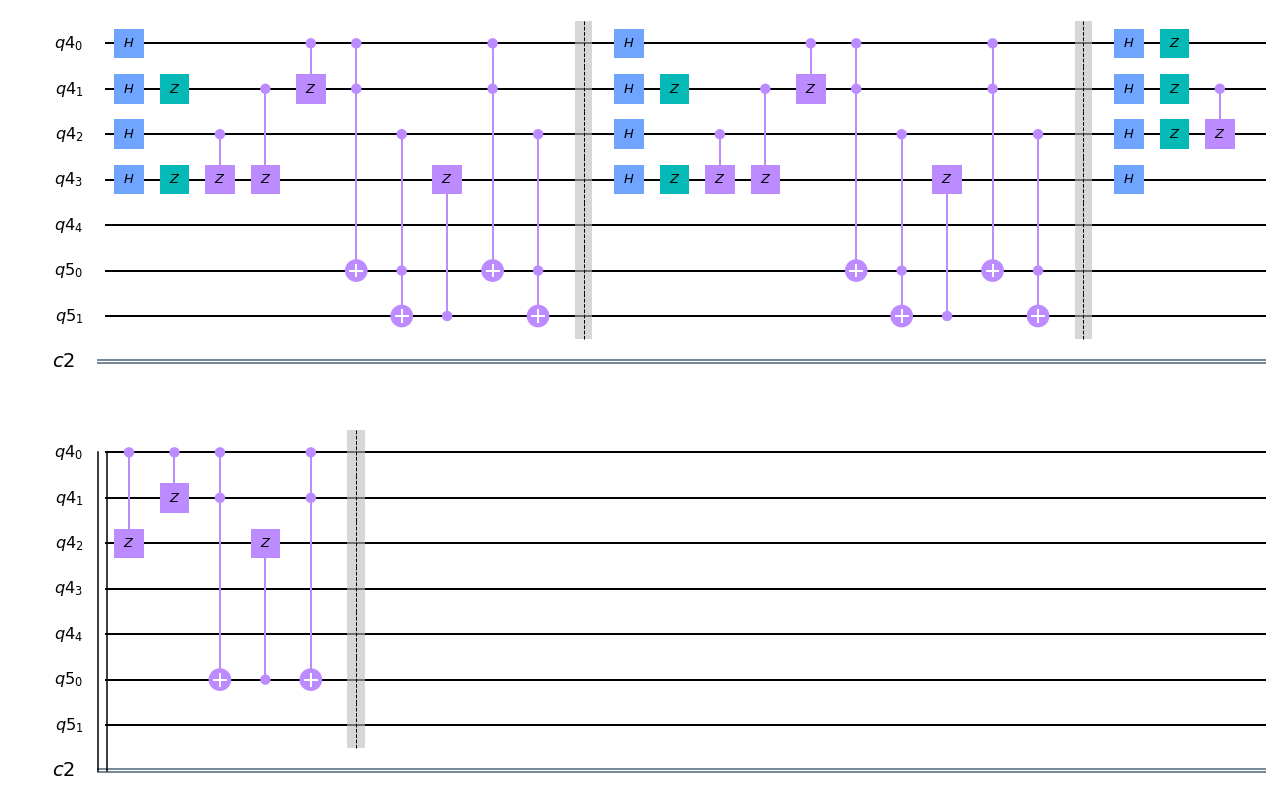

In [21]:
for i in range(4):
    circuit.h(q[i])

generateU(inputV)

circuit.draw(output='mpl')

### Matriz Uw - Pesos da Rede Neural Quântica
![](img/image18.png)

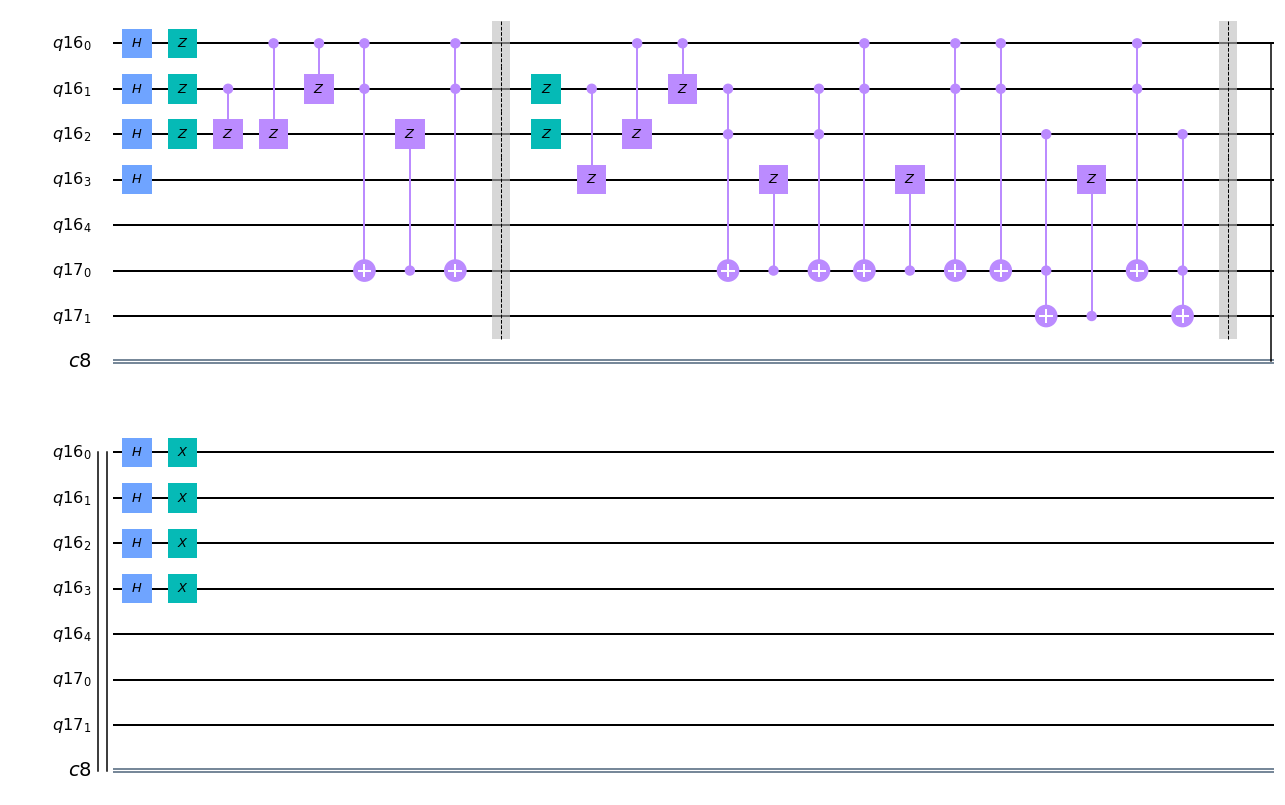

In [60]:
generateU(weightsV)

for i in range(4):
    circuit.h(q[i])
    circuit.x(q[i])

circuit.draw(output='mpl')

### Toffoli final e medição
![](img/image19.png)

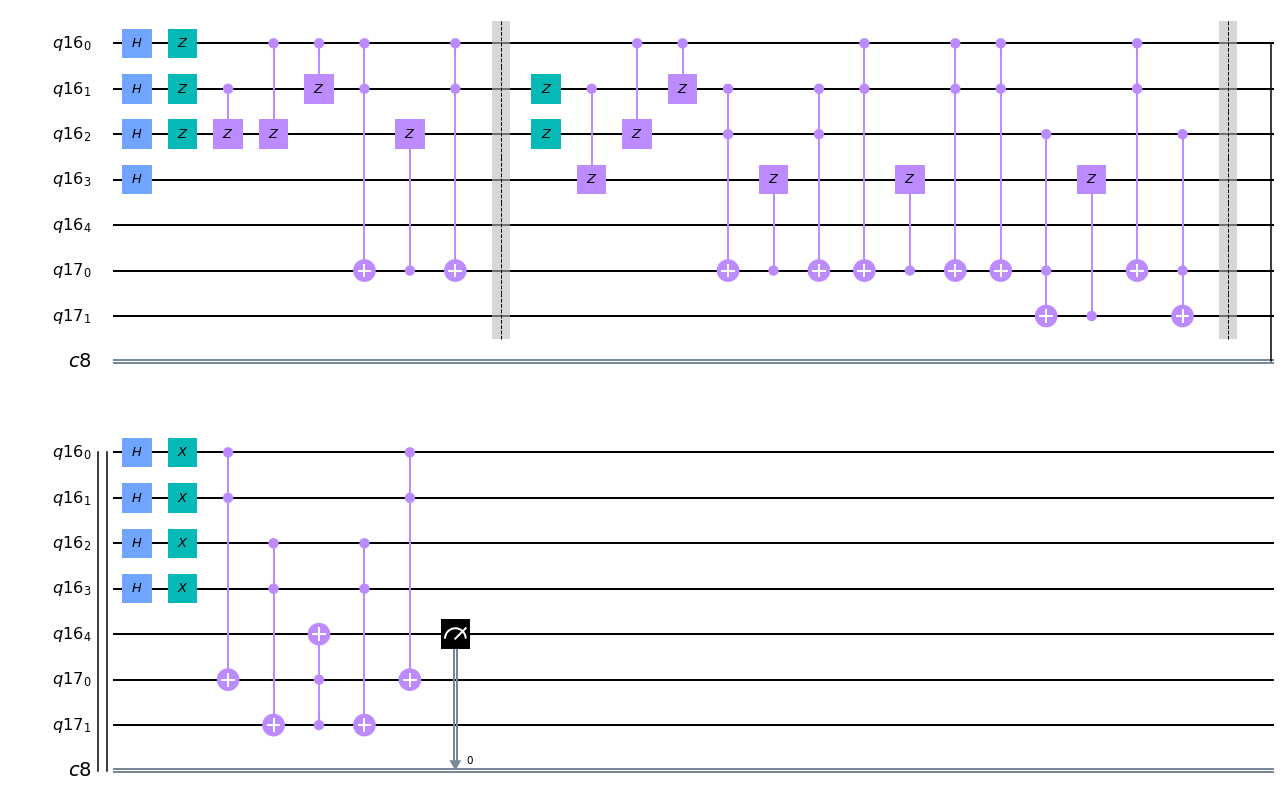

In [61]:
circuit = ccccx(circuit, q[0], q[1], q[2], q[3], q[4], aux[0], aux[1])
circuit.measure(q[4], c[0])
    
circuit.draw(output='mpl')

## Implementação - Força Bruta

### Sign-flip Algorithm

states marked:  0000
states marked:  0001
states marked:  1010


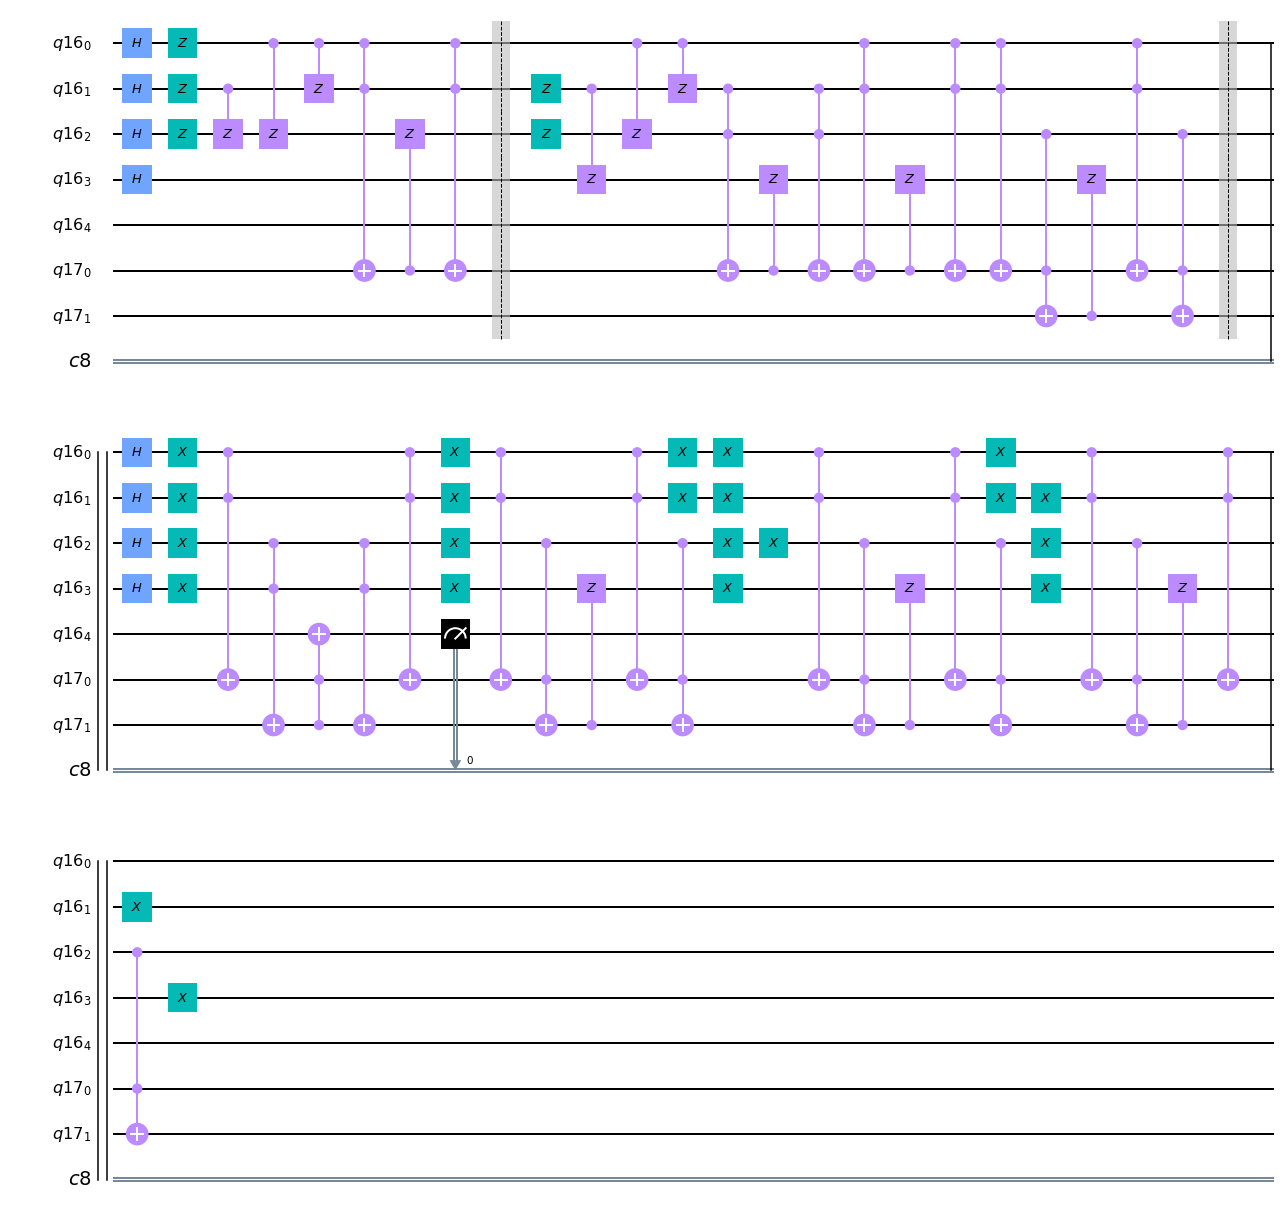

In [62]:
#========================================================
# MARK EACH STATE FROM THE IMAGE MATRIX
#========================================================

matrix =  [1, 1, 0, 0,
          0, 0, 0, 0, 
          0, 0, 1, 0, 
          0, 0, 0, 0]

# capture number of qubits needed for the system
nbase_states = str( int(math.sqrt(len(matrix))) )
nbase_states = '{0:0'+nbase_states+'b}'

# function for automated UI SF generation
def autoMarkCircuitSF(matrix, circuit, nbase_states):
    ''' identify number of qubits needed for the base states,
        identify wich states to be marked, 
        create circuit based on state bits
    '''
    # identify positions to be marked with Z-GATE
    circuits_config = []
    for i in range(len(matrix)):
        if matrix[i] == 1:
            state_bits = nbase_states.format(i)
            print('states marked: ',state_bits)
            # apply NOT to qubits with '0' in position
            for bit_index in range(len(state_bits)): 
                if state_bits[bit_index] == '0':
                    circuit.x(q[bit_index])
            # MARK STATE 
            cccz(circuit, q[0], q[1], q[2], q[3], aux[0], aux[1]) # MARK STATE 
            # apply NOT to qubits with '0' in position
            for bit_index in range(len(state_bits)): 
                if state_bits[bit_index] == '0':
                    circuit.x(q[bit_index])
    return circuit

# apply UI
autoMarkCircuitSF(matrix, circuit, nbase_states)

circuit.draw(output='mpl')

### Algoritmo Quine–McCluskey 

A decisão de quais portas serão adotas para a construção do circuito de forma que a quantidade utilizada seja a mímima possível é um problema encontrado na computação clássica. Atualmente, existe uma estratégia conhecida como mapa de Karnaugh que realiza simplificações identificando uma das soluções com a melnor quantidade de portas para identificar um determinado sinal, no entanto essa estratégia funciona bem quando o circuito em questão possui menos de 5 variáveis, visto que a mesma utiliza um mapa para organizar os elementos. Ao utlizar 5 variáveis o mapa de Karnaugh sai do plano e começa a representar os elementos por um hipercubo, sendo assim conforme a quantidade de variáveis aumentam a visualização começa a se tornar inviável. 

Diante dessa dificuldade surge o algoritmo Quine–McCluskey proposto por Willard V. Quine que é um melhoramento da versão proposta por Edward J. McCluskey. Esse algoritmo consegue simplificar um determinado circuito com mais de 5 variáveis, no entanto, esse algoritmo tem complexidade exponencial. Considerando $n$ o número de primos implicantes a complexidade do algoritmo é $3^nln(n)$. Abaixo segue um exemplo da utilização desse algoritmo:

In [5]:
from itertools import combinations

def simplify(elements):
    result = set(elements)
    for b1, b2 in combinations(result, 2): 
        for i in range(len(b1)):
            if b1[:i] + b1[i+1:] == b2[:i] + b2[i+1:]:
                merged = "-".join([b1[:i], b1[i+1:]])
                return sorted(simplify(result ^ {b1, b2, merged}))
    return sorted(result)

In [6]:
elements = ['1100', '1000', '0100', '0000', '1111', '1011', '0111', '0011']

pattern = simplify(elements)
print(pattern)

['--00', '--11']


In [8]:
elements = ['11', '10', '01', '00']

pattern = simplify(elements)
print(pattern)

['--']
